In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score,classification_report, confusion_matrix

In [2]:
df = pd.read_csv('water_potability.csv')

In [3]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Text(0, 0.5, 'Percentage of missing values')

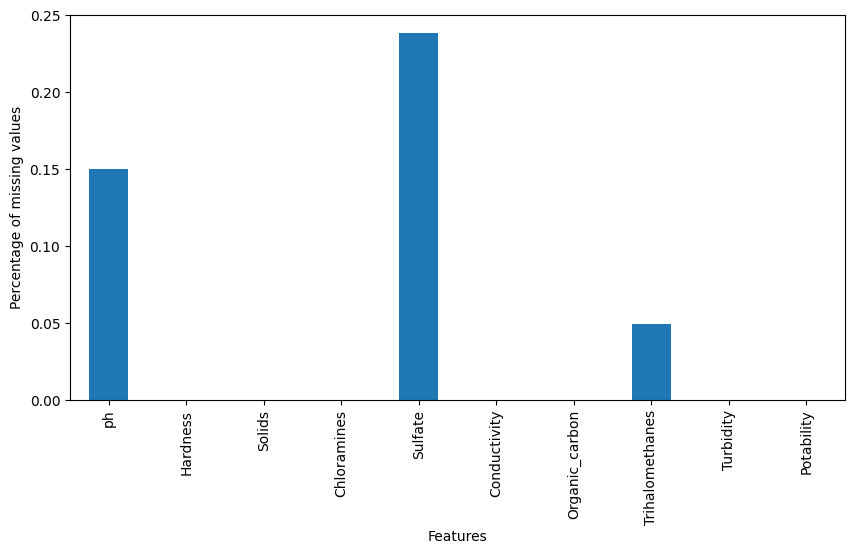

In [4]:
#handling null values
df.isnull().mean().plot.bar(figsize=(10,5))
plt.xlabel("Features")
plt.ylabel("Percentage of missing values")

In [5]:
df["ph"]=df["ph"].fillna(df["ph"].mean())
df["Sulfate"]=df["Sulfate"].fillna(df["Sulfate"].mean())
df["Trihalomethanes"]=df["Trihalomethanes"].fillna(df["Trihalomethanes"].mean())

In [6]:
#handling outlier
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
print("After outlier removal:", df.shape)

After outlier removal: (2666, 10)


In [8]:
x = df.drop('Potability', axis=1)
y = df['Potability']

In [15]:
#Handle Imbalance using SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
print("After SMOTE:", X.shape, "Target distribution:\n", y.value_counts())

After SMOTE: (2666, 9) Target distribution:
 Potability
0    1671
1    1671
Name: count, dtype: int64


In [16]:
scaler=StandardScaler()
x=scaler.fit_transform(x)

In [17]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42)

In [20]:
from xgboost import XGBClassifier

In [21]:
# 8️⃣ XGBoost Model + Grid Search

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid = GridSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(x_train, y_train)

print("\n✅ Best Hyperparameters:", grid.best_params_)
print("✅ Best CV Accuracy:", grid.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\Neelabh\OneDrive\Documents\ml learn2\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:31:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
✅ Best CV Accuracy: 0.6872442157583394


In [22]:
# 9️⃣ Final Model Evaluation

best_model = grid.best_estimator_
y_pred = best_model.predict(x_test)

print("\n🎯 Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



🎯 Test Accuracy: 0.7100149476831091

Confusion Matrix:
 [[252  91]
 [103 223]]

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.73      0.72       343
           1       0.71      0.68      0.70       326

    accuracy                           0.71       669
   macro avg       0.71      0.71      0.71       669
weighted avg       0.71      0.71      0.71       669



In [23]:
# 🔟 Cross-validation Stability Check
# ==============================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, x, y, cv=cv, scoring='accuracy')
print("\n📊 Cross-Validation Accuracies:", cv_scores)
print("📈 Mean CV Accuracy:", cv_scores.mean())


c:\Users\Neelabh\OneDrive\Documents\ml learn2\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:42:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Neelabh\OneDrive\Documents\ml learn2\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:42:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Neelabh\OneDrive\Documents\ml learn2\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:42:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Neelabh\OneDrive\Documents\ml learn2\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:42:24] WARNING: C:\actions-runner\_work\


📊 Cross-Validation Accuracies: [0.67115097 0.71449925 0.69461078 0.71856287 0.74850299]
📈 Mean CV Accuracy: 0.7094653741843666
